In [ ]:
import torch
import os
import torchaudio
from torchaudio import datasets
import numpy as np
import random

import torchaudio.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from torch.utils.data import random_split


import matplotlib.pyplot as plt
import librosa


### Load datasets

In [ ]:
# Load dataset
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

100%|██████████| 5.95G/5.95G [04:48<00:00, 22.1MB/s]
100%|██████████| 331M/331M [00:17<00:00, 19.9MB/s]


In [ ]:
train_dataset[0]

(tensor([[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]]),
 16000,
 'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK',
 103,
 1240,
 0)

### Datasets Visualization
#### **Mel Spectogram**

In [ ]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    """
    Plots the waveform of a audio signal.
    """
    waveform = np.array(waveform)

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    """
    Plots the spectrogram of a audio signal.
    """
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

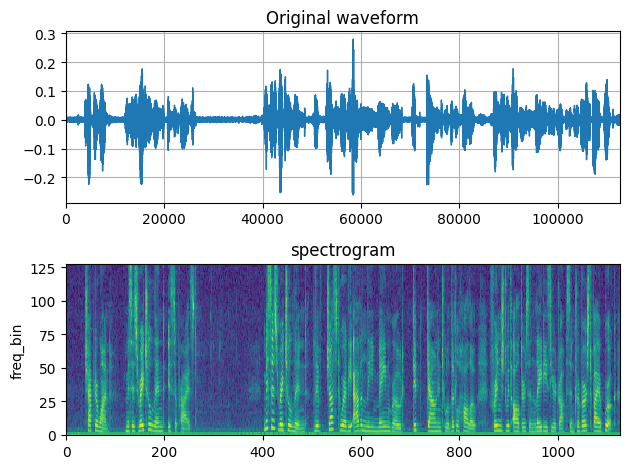

In [ ]:
SAMPLE_RATE = 2

# Create function to transform
transform = T.MelSpectrogram(sample_rate=SAMPLE_RATE)

# Get first audio of the dataset to do test
first_audio = train_dataset[0][0]

# apply transformation
mel_Specgram = transform(first_audio)

fig, axs = plt.subplots(2, 1)
plot_waveform(first_audio, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(mel_Specgram[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

#### **MFCC**

CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK


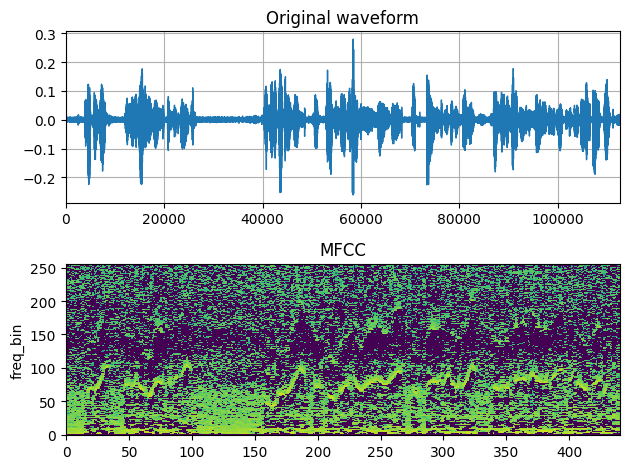

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(first_audio)

fig, axs = plt.subplots(2, 1)
plot_waveform(first_audio, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(mfcc[0], title="MFCC", ax=axs[1])
fig.tight_layout()
print(train_dataset[0][2])

### Datasets Processing
##### **Define metrics functions**

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """
    This method calculates the levenshtein distance between a reference string and a hypothesis string.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """
    This method calculates the word error rate between a reference string and a hypothesis string.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """
    This method calculates the char error rate between a reference string and a hypothesis string.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """
    This method calculates the word error rate between a reference string and a hypothesis string.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """
    This method calculates the char error rate between a reference string and a hypothesis string.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer



##### **Define preprocessing functions**

Basically, we want to convert sequence of char into sequence of int and use padding to get sequence of same length

In [ ]:
char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""

class TextTransform:
    """
    Maps characters to integers and vice versa
    """

    def __init__(self):
        self.char_map_str = char_map_str
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """
        Converts a string to its character integer representation.
        """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels) -> list:
        """
        Converts an integer label to its string representation.
        """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('', ' ')

train_audio_transforms = nn.Sequential(
    T.MelSpectrogram(sample_rate=16000, n_mels=128),
    T.FrequencyMasking(freq_mask_param=15), # Data Augmentation
    T.TimeMasking(time_mask_param=35) # Data Augmentation
)

valid_audio_transforms = T.MelSpectrogram()
text_transform = TextTransform()

def data_processing(data, data_type="train"):
    """
    Apply transformation to the data and process it to be ready to use.
    """
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### Model Training

We use a Greedy decoder for simplicity.

In [ ]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    """
    Decodes the output of the model.
    """
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [ ]:
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    """
    Train the model.
    """
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data

        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(spectrograms), data_len, 100. * batch_idx / len(train_loader), loss.item()))


In [ ]:
def test(model, device, test_loader, criterion):
    """
    Test the model.
    """
    print('\nevaluating…')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for I, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

For now, we choose arbitrarily the HyperParameters

In [ ]:
N_CNN_LAYERS = 3
N_RNN_LAYERS = 5
RNN_DIM = 512

N_CLASS = 29
N_FEATS = 128

HIDDEN_SIZE = 128
STRIDE = 2
DROPOUT = 0.1

LEARNING_RATE = 5e-4
BATCH_SIZE = 20
EPOCHS = 100

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
def main(train_dataset, test_dataset, model):
    """
    Main function to apply all the steps.
    """
    torch.manual_seed(0)

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: data_processing(x, 'train'))
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: data_processing(x, 'valid'))

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), LEARNING_RATE)
    criterion = nn.CTCLoss(blank=28).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=EPOCHS,
                                            anneal_strategy='linear')

    for epoch in range(1, EPOCHS + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
        test(model, device, test_loader, criterion)


# We use only 5% of the dataset to train faster
subset_size_train = int(0.05 * len(train_dataset))
train_dataset_subset, _ = random_split(train_dataset, [subset_size_train, len(train_dataset) - subset_size_train])

subset_size_test = int(0.05 * len(test_dataset))
test_dataset_subset, _ = random_split(test_dataset, [subset_size_test, len(test_dataset) - subset_size_test])

##### **Simple MLP**

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, n_feats, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        n_feats = n_feats//2
        self.fc1 = nn.Linear(hidden_size, hidden_size*2)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])
        x = x.transpose(1, 2)
        x = self.fc1(x)

        x = self.classifier(x)
        return x

In [ ]:
model = SimpleMLP(n_feats=N_FEATS, hidden_size=HIDDEN_SIZE, num_classes=N_CLASS).to(device)

main(train_dataset=train_dataset_subset, test_dataset=test_dataset_subset, model=model)

SimpleMLP(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=29, bias=True)
  )
)
Num Model Parameters 69661
Train Epoch: 1 [0/1426 (0%)]	Loss: 6.512302

evaluating…
Test set: Average loss: 5.9187, Average CER: 0.672566 Average WER: 0.9568

Train Epoch: 2 [0/1426 (0%)]	Loss: 5.937821

evaluating…
Test set: Average loss: 4.7854, Average CER: 0.963331 Average WER: 0.6748

Train Epoch: 3 [0/1426 (0%)]	Loss: 4.248998

evaluating…
Test set: Average loss: 4.3666, Average CER: 0.999305 Average WER: 0.7243

Train Epoch: 4 [0/1426 (0%)]	Loss: 3.898718

evaluating…
Test set: Average loss: 4.1244, Average CER: 1.000000 Average WER: 0.9723

Train Epoch: 5 [0/1426 (0%)]	Loss: 3.898274

evaluating…
Test set: Average loss: 3.9712, Average CER: 1.000000 Average WER: 0.9740

Train Epoch: 6 [0/1426 (0%)]	Loss: 3.638301

eval

##### **bi-GRU model**

In [ ]:
class CNNLayerNorm(nn.Module):
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [25]:
model_gru = SpeechRecognitionModel(N_CNN_LAYERS, N_RNN_LAYERS, RNN_DIM, N_CLASS, N_FEATS, STRIDE, DROPOUT).to(device)

main(train_dataset=train_dataset_subset, test_dataset=test_dataset_subset, model=model_gru)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

## Fine tune WAVE2VEC for emotion recognition

In [ ]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install torchaudio
!pip install librosa

!pip install accelerate -U

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import librosa
import os
import sys

import torch
import torchaudio
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import accelerate

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from datasets import load_dataset, load_metric
from dataclasses import dataclass
from typing import Optional, Tuple

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)

from dataclasses import dataclass
from typing import Dict, List, Optional, Union

import transformers
from transformers import EvalPrediction
from transformers import AutoConfig, Wav2Vec2Processor
from transformers.file_utils import ModelOutput
from transformers import Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/djulo/.local/lib/python3.11/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
2023-11-25 01:52:16.782370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 01:52:17.968985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Device: cpu


In [2]:
path = "oreau-fr/"
emotions_folders = [path +  "anger", path+"disgust", path+"fear", path+"joy", path+"sadness", path+"surprise"]

data = []

for emotion_folder in emotions_folders:
    for path in tqdm(Path(emotion_folder).glob("**/*.wav")):
        name = str(path).split('/')[-1].split('.')[0]
        label = emotion_folder.split('/')[-1]  # Utilisez le dernier élément du chemin comme étiquette émotionnelle

        try:
            # Il y a quelques fichiers corrompus
            s, _ = torchaudio.load(path)
            data.append({
                "name": name,
                "path": path,
                "emotion": label
            })
        except Exception as e:
            # print(str(path), e)
            pass



df = pd.DataFrame(data)
df

67it [00:00, 277.33it/s]
67it [00:00, 252.36it/s]
51it [00:00, 300.26it/s]
62it [00:00, 348.64it/s]
55it [00:00, 274.40it/s]
62it [00:00, 317.33it/s]


,name,path,emotion
0,07a02Ca,oreau-fr/anger/07a02Ca.wav,anger
1,07a03Ca,oreau-fr/anger/07a03Ca.wav,anger
2,07a04Ca,oreau-fr/anger/07a04Ca.wav,anger
3,07a10Ca,oreau-fr/anger/07a10Ca.wav,anger
4,08a03Ca,oreau-fr/anger/08a03Ca.wav,anger
...,...,...,...
359,24a06Sa,oreau-fr/surprise/24a06Sa.wav,surprise
360,37a01Sa,oreau-fr/surprise/37a01Sa.wav,surprise
361,37a06Sa,oreau-fr/surprise/37a06Sa.wav,surprise
362,42a07Sa,oreau-fr/surprise/42a07Sa.wav,surprise


In [3]:
save_path = "data"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(291, 3)
(73, 3)


In [4]:
data_files = {
    "train": "data/train.csv",
    "validation": "data/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Generating train split: 291 examples [00:00, 39666.64 examples/s]
Generating validation split: 73 examples [00:00, 20018.58 examples/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 291
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 73
})


In [5]:
# We need to specify the input and output column
input_column = "path"
output_column = "emotion"

# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 6 classes: ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']


In [6]:
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-french"
pooling_mode = "mean"

config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

In [7]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


### Preprocess Data

In [8]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)

    speech_array = speech_array[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech_array), orig_sr=sampling_rate, target_sr=16_000)
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [9]:
train_dataset_prepoc = train_dataset.map(
    preprocess_function,
    batch_size=32,
    batched=True,
    num_proc=4
)

eval_dataset_prepoc = eval_dataset.map(
    preprocess_function,
    batch_size=32,
    batched=True,
    num_proc=4
)

Map (num_proc=4): 100%|██████████| 73/73 [00:01<00:00, 44.71 examples/s]


### Model


In [ ]:
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [ ]:
class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

is_regression = False

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

model.freeze_feature_extractor()

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-french and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS = 10.0

# Define your training arguments
training_args = TrainingArguments(
    output_dir="/content/wav2vec2-emotion_recognition",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=EPOCHS,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_prepoc,
    eval_dataset=eval_dataset_prepoc,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)


### Uncomment to train the model ###
####################################

#trainer.train()
#trainer.save_model("wav2vec2-emotion_recognition_model") # Save the model
#loaded_model = model

Step,Training Loss,Validation Loss,Accuracy
10,0.015900,1.034085,0.780822
20,0.111800,1.792833,0.712329
30,0.279900,0.584508,0.835616
40,0.133600,0.706510,0.863014
50,0.024900,0.565143,0.890411
60,0.041200,0.551603,0.904110
70,0.032600,0.480054,0.917808
80,0.008600,0.445144,0.917808
90,0.016600,0.381892,0.945205
100,0.103600,0.356149,0.958904


TrainOutput(global_step=108, training_loss=0.0726691586551843, metrics={'train_runtime': 674.6049, 'train_samples_per_second': 1.294, 'train_steps_per_second': 0.16, 'total_flos': 9.670927382082102e+16, 'train_loss': 0.0726691586551843, 'epoch': 2.96})

In [ ]:
# Load a model
from transformers import Wav2Vec2ForSequenceClassification

# Load our model From HuggingFace Hub
loaded_model = Wav2Vec2ForSequenceClassification.from_pretrained("Djulo/wav2vec2-emotion_recognition_model_fr")

config.json: 100%|██████████| 2.70k/2.70k [00:00<00:00, 210kB/s]
model.safetensors: 100%|██████████| 1.27G/1.27G [03:41<00:00, 5.72MB/s]


### Evaluating the model on other audios

In [ ]:
loaded_model.eval()

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=

In [ ]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [ ]:
def predict_single_sample(sample):
    speech_array, sampling_rate = torchaudio.load(sample)

    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), orig_sr=sampling_rate, target_sr=processor.feature_extractor.sampling_rate)

    features = processor(speech_array, sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = loaded_model(input_values, attention_mask=attention_mask).logits

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()

    return pred_ids

In [ ]:
sample_joy1 = "evaluation_audios/joy_1.wav"
sample_joy2 = "evaluation_audios/joy_2.wav"
sample_anger1 = "evaluation_audios/anger_1.wav"
sample_disgust1 = "evaluation_audios/disgust_1.wav"

sample_result_joy1 = predict_single_sample(sample_joy1)
print(f"Sample Path: {sample_joy1}, Predicted: {sample_result_joy1}, Expected: Joy")
print("="*50)

sample_result_joy2 = predict_single_sample(sample_joy2)
print(f"Sample Path: {sample_joy2}, Predicted: {sample_result_joy2}, Expected: Joy")
print("="*50)

sample_result_anger1 = predict_single_sample(sample_anger1)
print(f"Sample Path: {sample_anger1}, Predicted: {sample_result_anger1}, Expected: Anger")
print("="*50)

sample_result_disgust1 = predict_single_sample(sample_disgust1)
print(f"Sample Path: {sample_disgust1}, Predicted: {sample_result_disgust1}, Expected: Disgust")

Sample Path: evaluation_audios/joy_1.wav, Predicted: [1], Expected: Joy
Sample Path: evaluation_audios/joy_2.wav, Predicted: [1], Expected: Joy
Sample Path: evaluation_audios/anger_1.wav, Predicted: [5], Expected: Anger
Sample Path: evaluation_audios/disgust_1.wav, Predicted: [1], Expected: Disgust
